# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.


In [179]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/APS360\ Lab_2_Cats_vs_Dogs.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/APS360 Lab_2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 2324645 bytes to /content/gdrive/MyDrive/Colab Notebooks/APS360 Lab_2_Cats_vs_Dogs.html


## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1LjEV6T7lndHAJkz63oeq-lXiHiqKNsnJ?usp=sharing


In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

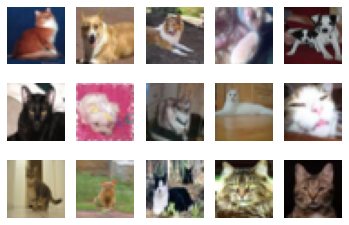

In [159]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [160]:
print("There are a total of", len(train_loader), "training cat and dog data points")
print("There are a total of", len(val_loader), "validation cat and dog data points")
print("There are a total of", len(test_loader), "test cat and dog data points")

There are a total of 125 training cat and dog data points
There are a total of 32 validation cat and dog data points
There are a total of 32 test cat and dog data points


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
# The validation set is an unbiased set of data that can be used to judge the fit of our model.
# We can see if our model is overfitted, underfitted, etc...
# Since the model is learning from the training data it becomes biased and so does not
# give a reasonablly good picture as to how our model will perform on unknown data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [4]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [5]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [6]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [161]:
num_param_small = 0
num_param_large = 0

# Interate through the parameters and count the number of elements in each tensor
for param in small_net.parameters():
  num_param_small += torch.numel(param)

for param in large_net.parameters():
  num_param_large += torch.numel(param)

print("There are", num_param_small, " parameters in small net")
print("There are", num_param_large, " parameters in large net")

There are 386  parameters in small net
There are 9705  parameters in large net


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [7]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [162]:
print("batch_size=64, learning_rate=0.01, num_epochs=30")

batch_size=64, learning_rate=0.01, num_epochs=30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [163]:
# There are a total of 9 files made.
# 5 model files and 4 error/loss csv files

for i in range(0, 5):
  file_name = get_model_name(small_net.name, batch_size=64, learning_rate=0.01, epoch=i)
  print(file_name)

print("{}_train_err.csv".format(file_name))
print("{}_train_loss.csv".format(file_name))
print("{}_val_err.csv".format(file_name))
print("{}_val_loss.csv".format(file_name))



model_small_bs64_lr0.01_epoch0
model_small_bs64_lr0.01_epoch1
model_small_bs64_lr0.01_epoch2
model_small_bs64_lr0.01_epoch3
model_small_bs64_lr0.01_epoch4
model_small_bs64_lr0.01_epoch4_train_err.csv
model_small_bs64_lr0.01_epoch4_train_loss.csv
model_small_bs64_lr0.01_epoch4_val_err.csv
model_small_bs64_lr0.01_epoch4_val_loss.csv


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

In [164]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.41825, Train loss: 0.67047976064682 |Validation err: 0.374, Validation loss: 0.6552983317524195
Epoch 2: Train err: 0.35725, Train loss: 0.6370871262550354 |Validation err: 0.362, Validation loss: 0.6517958547919989
Epoch 3: Train err: 0.338, Train loss: 0.6175777621269226 |Validation err: 0.337, Validation loss: 0.6210648324340582
Epoch 4: Train err: 0.324125, Train loss: 0.6020987010002137 |Validation err: 0.361, Validation loss: 0.630347752943635
Epoch 5: Train err: 0.31825, Train loss: 0.5959754271507263 |Validation err: 0.326, Validation loss: 0.620125450193882
Epoch 6: Train err: 0.305875, Train loss: 0.587960987329483 |Validation err: 0.3265, Validation loss: 0.6152410563081503
Epoch 7: Train err: 0.315375, Train loss: 0.5864705379009247 |Validation err: 0.329, Validation loss: 0.609989620745182
Epoch 8: Train err: 0.3115, Train loss: 0.5822273569107056 |Validation err: 0.3375, Vali

In [ ]:
# Small net: Total time elapsed: 105.72 seconds
# Large net: Total time elapsed: 120.88 seconds

# Large net took longer to train, most likely because it has more hidden layers
# which in turn increase the computation time on each itteration.  

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

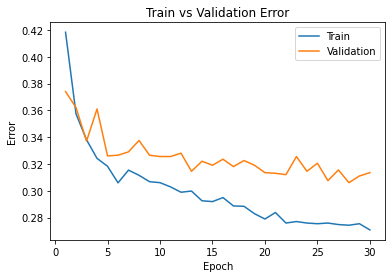

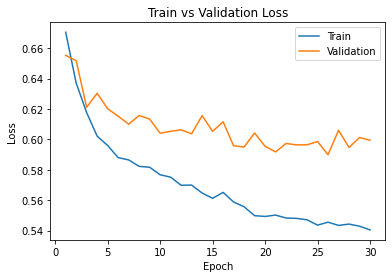

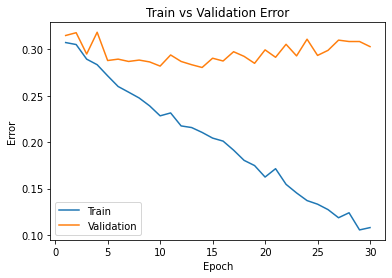

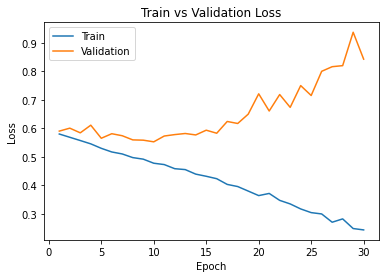

In [165]:
small_model_path = get_model_name(small_net.name, batch_size=64, learning_rate=0.01, epoch=29)
large_model_path = get_model_name(large_net.name, batch_size=64, learning_rate=0.01, epoch=29)

plot_training_curve(small_model_path)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# The first thing to notice is that the large net has far less variation in the 
# error and loss curves. Compared to the small net which fluctuated heavily

# The starting error for the large net is quite high but rapidly decreases 
# over several epochs. Whereas the small net starting error is relatively low but 
# only decreases that error by about 1% over 30 epochs compared to the large nets
# 30% over 30 epochs. 

# The large net model looks to be overfitted to the training data. This is because
# the training curve and the validation curve split and go in opposite directions 
# starting around epoch 5. 

# The small net model also looks to be underfitted because  the loss plot for 
# both stay completely seperated from one another. A well fit model would have the
# training data and validation set loss curves be converging towards zero with 
# increasing epochs.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

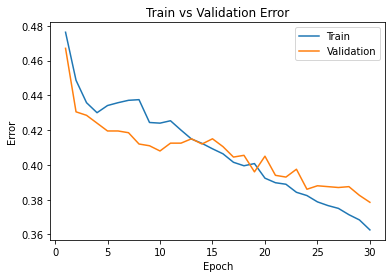

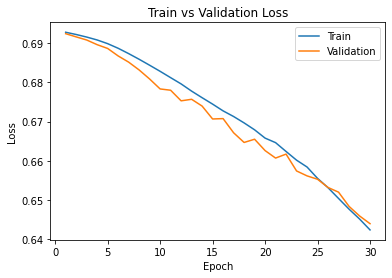

In [166]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
large_model_path = get_model_name(large_net.name, batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

# Total time elapsed: 144.57 seconds so the training took about %120 longer 

# The learning rate makes the step size when doing gradient descent smaller.
# This means that the model will jump around less, when approaching an optimal
# set of weights. However, the only problem is that we don't know if the minima 
# we're approaching is local or global. Either way, using a smaller learning rate
# in this case significantly improved the model, now it looks to be properly fit.
# However, the error is now higher compared to default parameters because the model
# didn't make sufficient strides towards a minima.  

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

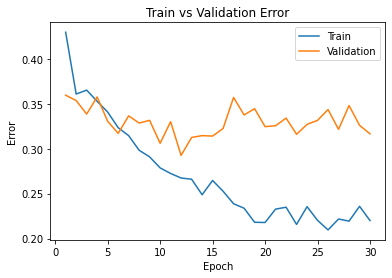

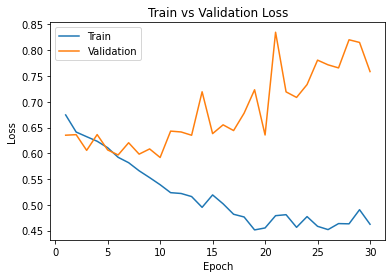

In [167]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
large_model_path = get_model_name(large_net.name, batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

# Total time elapsed: 141.79 seconds so compared to the previous time it is similar.
# but compared to the default parameters it still took longer

# By increasing the learning rate the step size in gradient descent increased 
# meaning that set of weights are less likely to approach the optimal set. 
# Judging from the training curves, the model now looks to be overfitted to the
# training data. The training error is acutally slightly higher than the 
# default most probably because it overshot/undershot (then overshot when compensating) 
# the minima 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

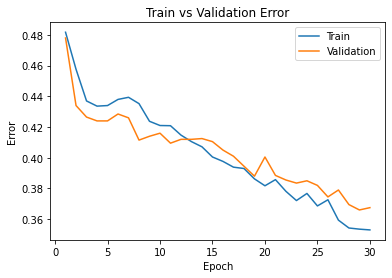

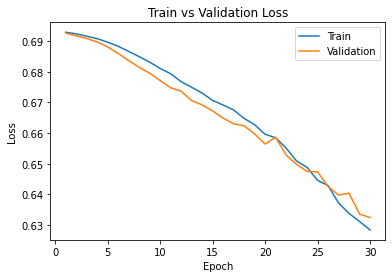

In [168]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
large_model_path = get_model_name(large_net.name, batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

# Total time elapsed: 113.38 seconds so this actually ran 6% faster than the 
# default parameters.

# The batch size indicates how many samples are used in estimating the error 
# gradient. So batch size will impact how fast the network can learn and the 
# stability of the learning process. In this case a larger batch size made the 
# training time faster but it increased our error, but it also made sure that the
# model wasn't over or under fitted.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

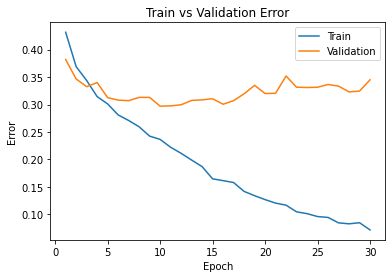

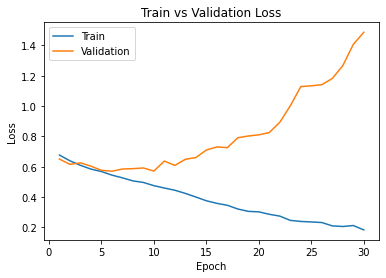

In [169]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
large_model_path = get_model_name(large_net.name, batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

# Total time elapsed: 187.41 seconds so the training took significantly longer
# compared to both the default and 512 batch size models

# Decreasing the batch size has made the learning process less stable and as such 
# the model is overfited to the training data. Plus it increased the training 
# time significantly with no benefit. 

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [170]:
# I think that by decreasing the batch size slightly it might improve the stability
# of the model, furthermore, I'm going to decrease the learning rate slightly
# this will hopefully make the model reach the optimal minima more steadily.
# Also the number of epochs was extended to give the model more time to get to
# the minima due to the lowered learning rate 

# Network: Large
# Learning rate: 0.01 -> 0.001
# Batch size: 64 -> 48
# Epochs: 30 -> 36

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.475375, Train loss: 0.6927504200421407 |Validation err: 0.45, Validation loss: 0.6922264865466526
Epoch 2: Train err: 0.44675, Train loss: 0.6919582500429211 |Validation err: 0.4275, Validation loss: 0.691148810443424
Epoch 3: Train err: 0.43525, Train loss: 0.6910141531578795 |Validation err: 0.4225, Validation loss: 0.6898983106726692
Epoch 4: Train err: 0.431625, Train loss: 0.6897660811504204 |Validation err: 0.422, Validation loss: 0.6878165247894469
Epoch 5: Train err: 0.435375, Train loss: 0.6881072292784731 |Validation err: 0.42, Validation loss: 0.685442613703864
Epoch 6: Train err: 0.432125, Train loss: 0.6861574792576407 |Validation err: 0.413, Validation loss: 0.6829803969178881
Epoch 7: Train err: 0.42775, Train loss: 0.6841867209194663 |Validation err: 0.411, Validation loss: 0.6807140069348472
Epoch 8: Train err: 0.424875, Train loss: 0.6820600311199349 |Validation err: 0.41

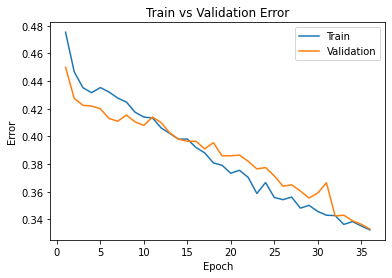

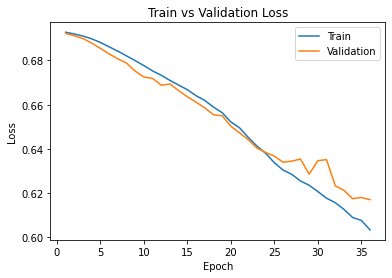

In [171]:
large_net = LargeNet()
train_net(large_net, batch_size=48, learning_rate=0.001, num_epochs=36)
large_model_path = get_model_name(large_net.name, batch_size=48, learning_rate=0.001, epoch=35)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# The model looks to be overfitting so let's try increasing the batch size.
# Furthermore, I'm going to reduce the number of epochs, and increase the learning
# rate to try to compensate for the increased batch size.  

# Network: Large
# Learning rate: 0.001 -> 0.002
# Batch size: 64 -> 56
# Epochs: 36 -> 24

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.478625, Train loss: 0.6923577977227164 |Validation err: 0.4485, Validation loss: 0.6892271422677569
Epoch 2: Train err: 0.43675, Train loss: 0.6881274197485063 |Validation err: 0.4305, Validation loss: 0.6850823495123122
Epoch 3: Train err: 0.42175, Train loss: 0.6837305493288107 |Validation err: 0.4225, Validation loss: 0.6795255011982388
Epoch 4: Train err: 0.41475, Train loss: 0.6787415113482442 |Validation err: 0.42, Validation loss: 0.673571315076616
Epoch 5: Train err: 0.4055, Train loss: 0.6745359989312979 |Validation err: 0.4155, Validation loss: 0.6696013179090288
Epoch 6: Train err: 0.399625, Train loss: 0.6706536091290988 |Validation err: 0.409, Validation loss: 0.6664849999878142
Epoch 7: Train err: 0.397, Train loss: 0.6674017964543163 |Validation err: 0.3985, Validation loss: 0.6621554361449348
Epoch 8: Train err: 0.394125, Train loss: 0.6632753139609223 |Validation err: 0.39

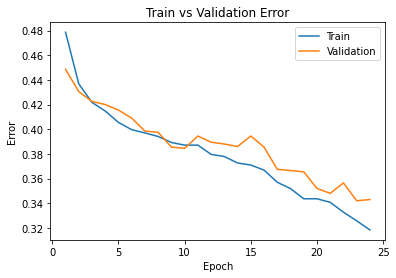

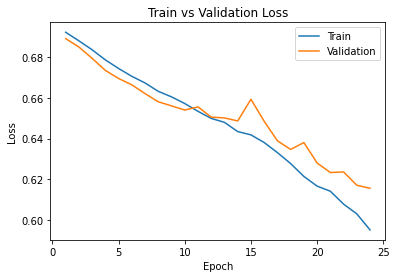

In [172]:
large_net = LargeNet()
train_net(large_net, batch_size=56, learning_rate=0.002, num_epochs=24)
large_model_path = get_model_name(large_net.name, batch_size=56, learning_rate=0.002, epoch=23)
plot_training_curve(large_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [173]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=56, learning_rate=0.002, epoch=23)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# This model is properly fit and performs well in both loss and error on the training
# and validation set. Furthermore, it seemed as though at a certain point adding 
# more epochs did nothing beneficial, and could acutally be detremental. So chosing
# the model with a slightly lower number of epochs was slightly more optimal.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [174]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

# Binary cross entropy with logistic loss
criterion = nn.BCEWithLogitsLoss()
train_error = evaluate(net, train_loader, criterion)
val_error = evaluate(net, val_loader, criterion)
test_error = evaluate(net, test_loader, criterion)

print("Training error, loss:", train_error[0], train_error[1])
print("Validation error, loss:", val_error[0], val_error[1])
print("Testing error, loss:",test_error[0], test_error[1])

Files already downloaded and verified
Files already downloaded and verified
Training error, loss: 0.31775 0.5917730278968811
Validation error, loss: 0.343 0.6171537283807993
Testing error, loss: 0.33 0.6115720849484205


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# The test error is slightly higher than the validation error. The test error was
# never used in any of the training so the model has never seen it before. 


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# We want to make sure that we test on a set of data that is completely unknown 
# and unbiased to the model, this is done in order to get an accurate reading 
# of how the model would perform in a real scenario. 
# Ideally testing is performed once, at the end of training and validation 
# this ensures that the model doesn't learn from the testing data, furthermore, 
# we use the testing set after adjusting all necessary hyperparameters in order 
# to ensure that we're not overfitting to the testing data.  

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

### Results: 

Finished Training 2 layer NN with: 48 0.004 16
Total time elapsed: 67.79 seconds
Training Error and loss: (0.118, 0.3222573105089679)
Validation Error and loss: (0.366, 0.728577366897038)

Finished Training 2 layer NN with: 48 0.004 30
Total time elapsed: 125.68 seconds
Training Error and loss: (0.041625, 0.13390086381556746)
Validation Error and loss: (0.3575, 1.0388423346337818)

Finished Training 2 layer NN with: 64 0.004 16
Total time elapsed: 63.56 seconds
Training Error and loss: (0.1495, 0.3777629268169403)
Validation Error and loss: (0.346, 0.6973823364824057)

Finished Training 2 layer NN with: 64 0.004 30
Total time elapsed: 115.13 seconds
Training Error and loss: (0.041625, 0.15790659564733506)
Validation Error and loss: (0.3565, 0.867885472252965)

Finished Training 2 layer NN with: 80 0.004 16
Total time elapsed: 62.21 seconds
Training Error and loss: (0.172, 0.414253416955471)
Validation Error and loss: (0.353, 0.6643578457832336)

Finished Training 2 layer NN with: 80 0.004 30
Total time elapsed: 111.64 seconds
Training Error and loss: (0.05225, 0.20334448978304864)
Validation Error and loss: (0.3585, 0.7853877091407776)

Finished Training 2 layer NN with: 96 0.004 16
Total time elapsed: 58.24 seconds
Training Error and loss: (0.1995, 0.4527051083388783)
Validation Error and loss: (0.361, 0.6580002790405637)

Finished Training 2 layer NN with: 96 0.004 30
Total time elapsed: 107.16 seconds
Training Error and loss: (0.07825, 0.25457287012111574)
Validation Error and loss: (0.35, 0.738883410181318)

Finished Training 2 layer NN with: 48 0.003 16
Total time elapsed: 67.37 seconds
Training Error and loss: (0.14875, 0.37770264350368593)
Validation Error and loss: (0.3555, 0.6891004350923357)

Finished Training 2 layer NN with: 48 0.003 30
Total time elapsed: 125.95 seconds
Training Error and loss: (0.0505, 0.17152775832992828)
Validation Error and loss: (0.3645, 0.9156802410171145)

Finished Training 2 layer NN with: 64 0.003 16
Total time elapsed: 62.97 seconds
Training Error and loss: (0.180875, 0.42687954330444333)
Validation Error and loss: (0.3535, 0.6650526393204927)


Finished Training 2 layer NN with: 64 0.003 30
Total time elapsed: 119.84 seconds
Training Error and loss: (0.0645, 0.22360053062438964)
Validation Error and loss: (0.3555, 0.7625381033867598)

Finished Training 2 layer NN with: 80 0.003 16
Total time elapsed: 60.57 seconds
Training Error and loss: (0.2135, 0.4705018651485443)
Validation Error and loss: (0.357, 0.6489945697784424)

Finished Training 2 layer NN with: 80 0.003 30
Total time elapsed: 111.84 seconds
Training Error and loss: (0.0865, 0.28032043769955634)
Validation Error and loss: (0.355, 0.7114389562606811)

Finished Training 2 layer NN with: 96 0.003 16
Total time elapsed: 58.87 seconds
Training Error and loss: (0.233, 0.4982119309050696)
Validation Error and loss: (0.359, 0.6438819482212975)

Finished Training 2 layer NN with: 96 0.003 30
Total time elapsed: 109.61 seconds
Training Error and loss: (0.11275, 0.3293455844478948)
Validation Error and loss: (0.3495, 0.679189662138621)

Finished Training 2 layer NN with: 48 0.002 16
Total time elapsed: 66.18 seconds
Training Error and loss: (0.193875, 0.44876029801939776)
Validation Error and loss: (0.35, 0.6558206649053664)

Finished Training 2 layer NN with: 48 0.002 30
Total time elapsed: 127.31 seconds
Training Error and loss: (0.077875, 0.2523622302238099)
Validation Error and loss: (0.354, 0.740625255164646)

Finished Training 2 layer NN with: 64 0.002 16
Total time elapsed: 61.11 seconds
Training Error and loss: (0.23575, 0.5003614127635956)
Validation Error and loss: (0.358, 0.6463504116982222)

Finished Training 2 layer NN with: 64 0.002 30
Total time elapsed: 118.15 seconds
Training Error and loss: (0.1125, 0.32993664681911467)
Validation Error and loss: (0.35, 0.6733346432447433)

Finished Training 2 layer NN with: 80 0.002 16
Total time elapsed: 59.42 seconds
Training Error and loss: (0.25375, 0.5282584062218666)
Validation Error and loss: (0.36, 0.6400938677787781)

Finished Training 2 layer NN with: 80 0.002 30
Total time elapsed: 111.15 seconds
Training Error and loss: (0.15425, 0.394343983232975)
Validation Error and loss: (0.352, 0.6554796075820923)

Finished Training 2 layer NN with: 96 0.002 16
Total time elapsed: 56.03 seconds
Training Error and loss: (0.2735, 0.5507048073978651)
Validation Error and loss: (0.3695, 0.6426814539091927)

Finished Training 2 layer NN with: 96 0.002 30
Total time elapsed: 108.91 seconds
Training Error and loss: (0.177125, 0.43315798328036353)
Validation Error and loss: (0.3535, 0.6445067042396182)

Finished Training 2 layer NN with: 48 0.001 16
Total time elapsed: 65.02 seconds
Training Error and loss: (0.2725, 0.550090255137689)
Validation Error and loss: (0.3615, 0.6398025325366429)

Finished Training 2 layer NN with: 48 0.001 30
Total time elapsed: 124.62 seconds
Training Error and loss: (0.18275, 0.43585812403056434)
Validation Error and loss: (0.3495, 0.6448658506075541)

Finished Training 2 layer NN with: 64 0.001 16
Total time elapsed: 61.05 seconds
Training Error and loss: (0.29625, 0.5767332634925842)
Validation Error and loss: (0.3685, 0.6435634847730398)

Finished Training 2 layer NN with: 64 0.001 30
Total time elapsed: 117.44 seconds
Training Error and loss: (0.218875, 0.4929287502765656)
Validation Error and loss: (0.3585, 0.6340661775320768)

Finished Training 2 layer NN with: 80 0.001 16
Total time elapsed: 59.60 seconds
Training Error and loss: (0.309, 0.5923591536283493)
Validation Error and loss: (0.3685, 0.6419368577003479)

Finished Training 2 layer NN with: 80 0.001 30
Total time elapsed: 116.51 seconds
Training Error and loss: (0.249, 0.528451279103756)
Validation Error and loss: (0.3665, 0.6365625762939453)

Finished Training 2 layer NN with: 96 0.001 16
Total time elapsed: 57.22 seconds
Training Error and loss: (0.318625, 0.602853386884644)
Validation Error and loss: (0.372, 0.6427666828745887)

Finished Training 2 layer NN with: 96 0.001 30
Total time elapsed: 108.36 seconds
Training Error and loss: (0.272625, 0.5520840524917557)
Validation Error and loss: (0.3695, 0.6397737264633179)





In [ ]:
# The 2 Layer neural net performed significantly worse than the convolution 
# neural net. No matter how I tuned the hyperparameters the model always seemed
# way too overfitted to the data. Maybe it would do better with more layers, but at 
# the current state the neural net was far worse in almost all aspects. 
# The best I could achieve was a 34% error on validation, which is pretty bad 
# considering that the CNN could get to 30% easily with minimal hyperparameter
# adjustment and it would not be overfitted. 

# Finished Training 2 layer NN with: batch size = 64, lr = 0.004, epoch = 16
# Total time elapsed: 63.56 seconds
# Training Error and loss: (0.1495, 0.3777629268169403)
# Validation Error and loss: (0.346, 0.6973823364824057)



In [72]:
# ANN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

In [113]:
# Model object
# define a 2-layer artificial neural network
class ANN_2L(nn.Module):
    def __init__(self):
        super(ANN_2L, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 300)
        self.layer2 = nn.Linear(300, 1)
        self.name = "ANN_2L"
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

In [154]:
# Initialize ANN and parameters
AI = ANN_2L() 

In [153]:
def eval(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [152]:
def train_ai(batch=64, learning_rate=0.01, num_epochs=15):
  model = ANN_2L() 
  
  # Load the data
  train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], batch_size=batch)

  torch.manual_seed(1000)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  
  # Set up some numpy arrays to store the training/test loss/erruracy
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  
  # Train the network
  # Loop over the data iterator and sample a new batch of training data
  # Get the output from the network, and optimize our loss function.
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      total_train_loss = 0.0
      total_train_err = 0.0
      total_epoch = 0

      for i, data in enumerate(train_loader, 0):
          # Get the inputs
          inputs, labels = data
          labels = normalize_label(labels) # Convert labels to 0/1

          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass, backward pass, and optimize
          outputs = model(inputs)
          outputs = outputs.squeeze()
          loss = criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          # Calculate the statistics
          corr = (outputs > 0.0).squeeze().long() != labels
          total_train_err += int(corr.sum())
          total_train_loss += loss.item()
          total_epoch += len(labels)

      train_err[epoch] = float(total_train_err) / total_epoch
      train_loss[epoch] = float(total_train_loss) / (i+1)
      val_err[epoch], val_loss[epoch] = eval(model, val_loader, criterion)
      
      # Save the current model (checkpoint) to a file
      model_path = get_model_name(model.name, batch, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)

  print('Finished Training 2 layer NN with:', batch, learning_rate, num_epochs)

  end_time = time.time()
  elapsed_time = end_time - start_time

  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  print("Training Error and loss:", eval(model, train_loader, nn.BCEWithLogitsLoss()))
  print("Validation Error and loss:", eval(model, val_loader, nn.BCEWithLogitsLoss()))
  
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.004 16
Total time elapsed: 67.79 seconds
Training Error and loss: (0.118, 0.3222573105089679)
Validation Error and loss: (0.366, 0.728577366897038)


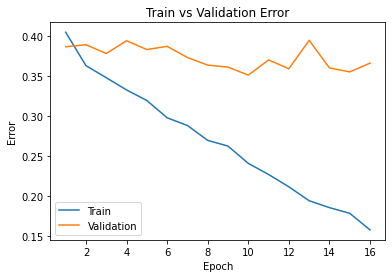

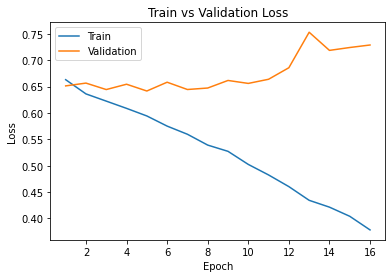

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.004 30
Total time elapsed: 125.68 seconds
Training Error and loss: (0.041625, 0.13390086381556746)
Validation Error and loss: (0.3575, 1.0388423346337818)


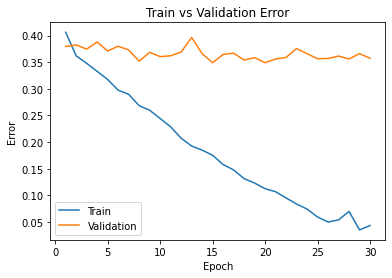

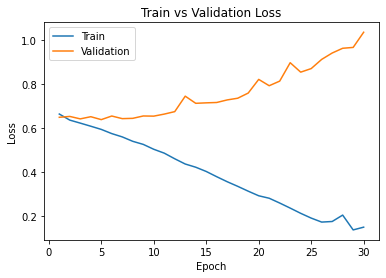

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.004 16
Total time elapsed: 63.56 seconds
Training Error and loss: (0.1495, 0.3777629268169403)
Validation Error and loss: (0.346, 0.6973823364824057)


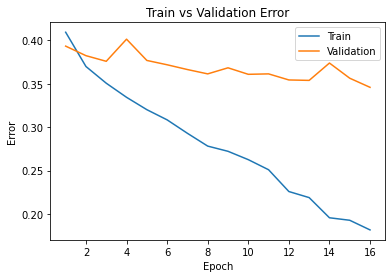

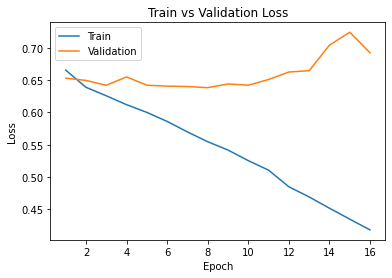

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.004 30
Total time elapsed: 115.13 seconds
Training Error and loss: (0.041625, 0.15790659564733506)
Validation Error and loss: (0.3565, 0.867885472252965)


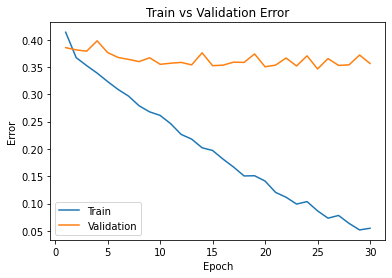

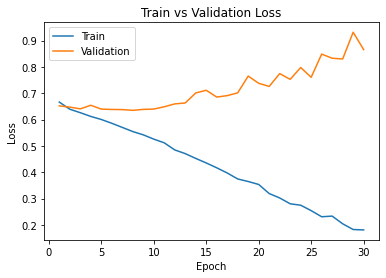

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.004 16
Total time elapsed: 62.21 seconds
Training Error and loss: (0.172, 0.414253416955471)
Validation Error and loss: (0.353, 0.6643578457832336)


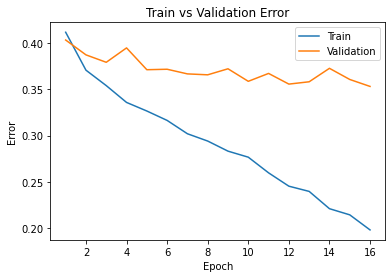

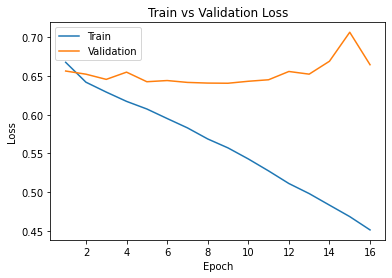

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.004 30
Total time elapsed: 111.64 seconds
Training Error and loss: (0.05225, 0.20334448978304864)
Validation Error and loss: (0.3585, 0.7853877091407776)


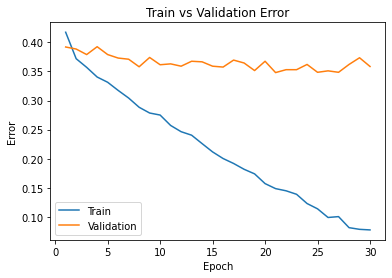

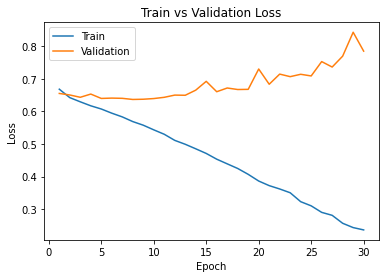

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.004 16
Total time elapsed: 58.24 seconds
Training Error and loss: (0.1995, 0.4527051083388783)
Validation Error and loss: (0.361, 0.6580002790405637)


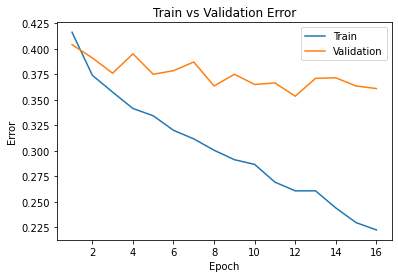

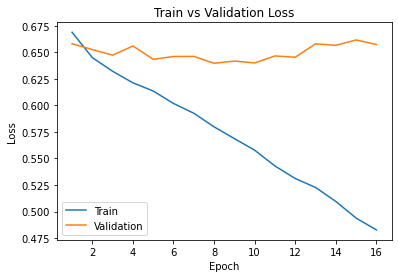

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.004 30
Total time elapsed: 107.16 seconds
Training Error and loss: (0.07825, 0.25457287012111574)
Validation Error and loss: (0.35, 0.738883410181318)


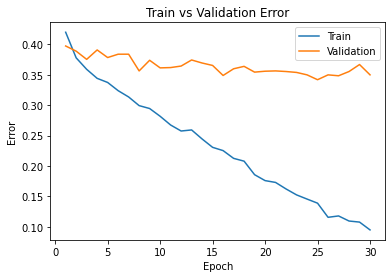

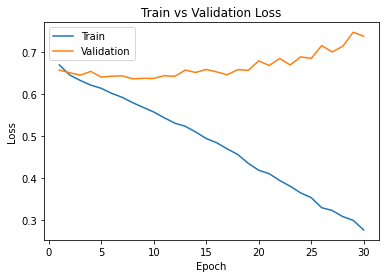

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.003 16
Total time elapsed: 67.37 seconds
Training Error and loss: (0.14875, 0.37770264350368593)
Validation Error and loss: (0.3555, 0.6891004350923357)


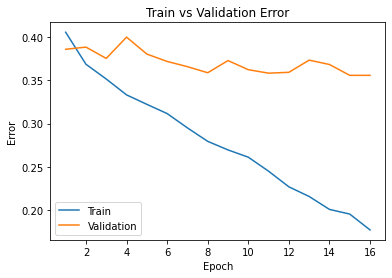

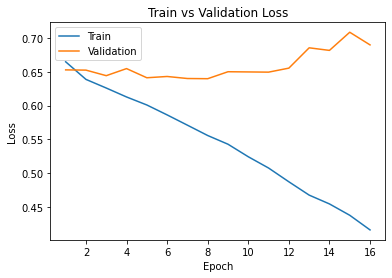

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.003 30
Total time elapsed: 125.95 seconds
Training Error and loss: (0.0505, 0.17152775832992828)
Validation Error and loss: (0.3645, 0.9156802410171145)


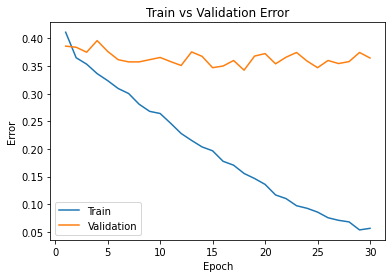

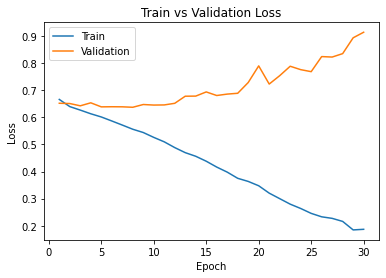

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.003 16
Total time elapsed: 62.97 seconds
Training Error and loss: (0.180875, 0.42687954330444333)
Validation Error and loss: (0.3535, 0.6650526393204927)


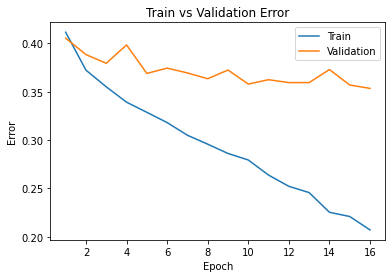

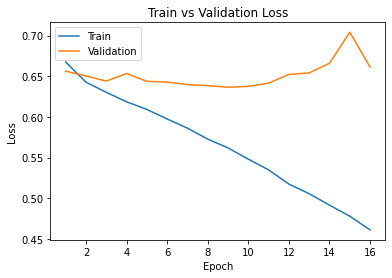

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.003 30
Total time elapsed: 119.84 seconds
Training Error and loss: (0.0645, 0.22360053062438964)
Validation Error and loss: (0.3555, 0.7625381033867598)


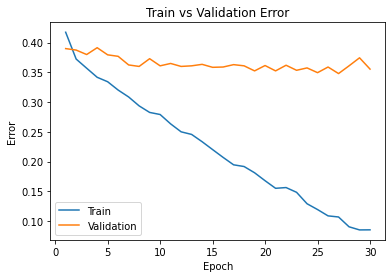

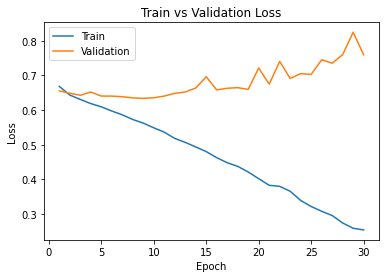

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.003 16
Total time elapsed: 60.57 seconds
Training Error and loss: (0.2135, 0.4705018651485443)
Validation Error and loss: (0.357, 0.6489945697784424)


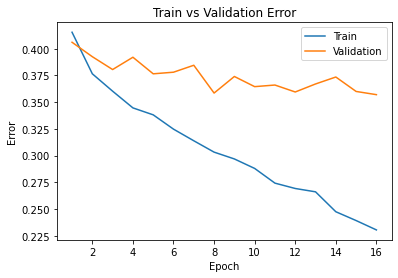

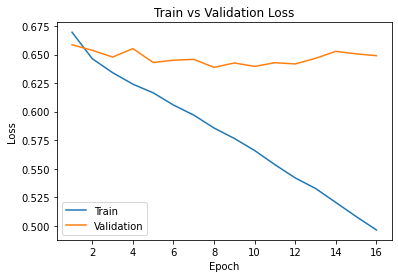

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.003 30
Total time elapsed: 111.84 seconds
Training Error and loss: (0.0865, 0.28032043769955634)
Validation Error and loss: (0.355, 0.7114389562606811)


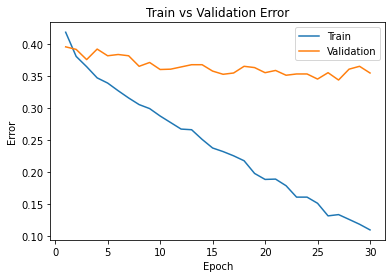

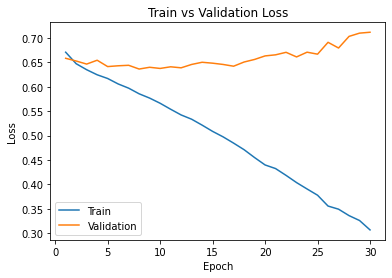

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.003 16
Total time elapsed: 58.87 seconds
Training Error and loss: (0.233, 0.4982119309050696)
Validation Error and loss: (0.359, 0.6438819482212975)


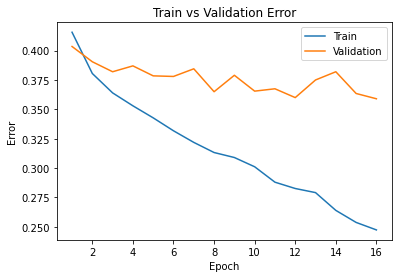

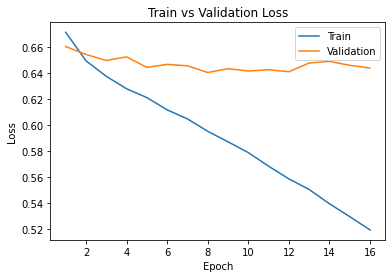

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.003 30
Total time elapsed: 109.61 seconds
Training Error and loss: (0.11275, 0.3293455844478948)
Validation Error and loss: (0.3495, 0.679189662138621)


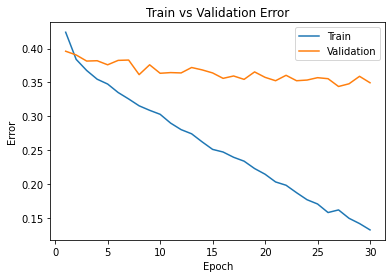

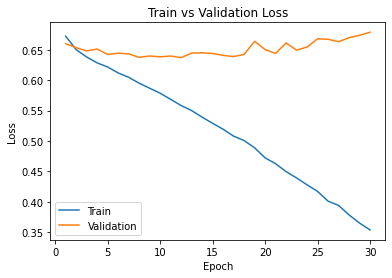

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.002 16
Total time elapsed: 66.18 seconds
Training Error and loss: (0.193875, 0.44876029801939776)
Validation Error and loss: (0.35, 0.6558206649053664)


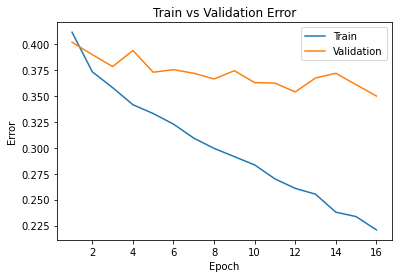

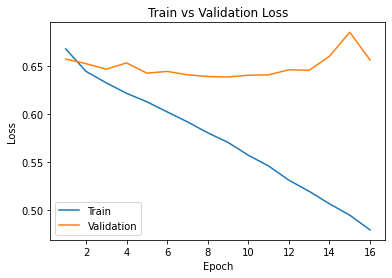

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.002 30
Total time elapsed: 127.31 seconds
Training Error and loss: (0.077875, 0.2523622302238099)
Validation Error and loss: (0.354, 0.740625255164646)


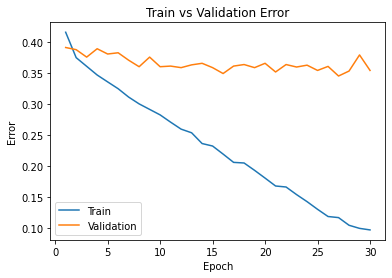

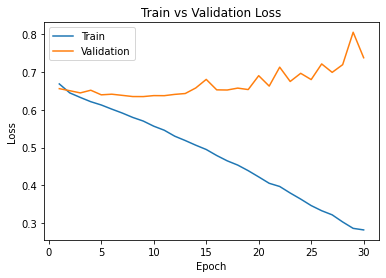

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.002 16
Total time elapsed: 61.11 seconds
Training Error and loss: (0.23575, 0.5003614127635956)
Validation Error and loss: (0.358, 0.6463504116982222)


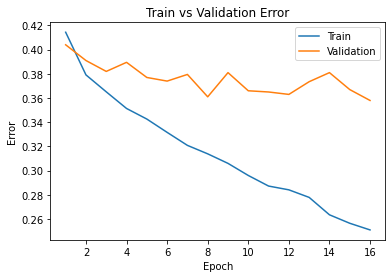

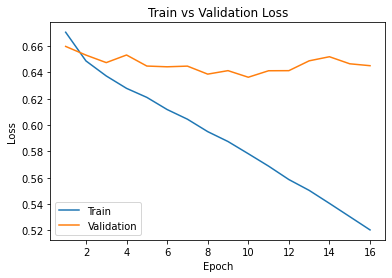

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.002 30
Total time elapsed: 118.15 seconds
Training Error and loss: (0.1125, 0.32993664681911467)
Validation Error and loss: (0.35, 0.6733346432447433)


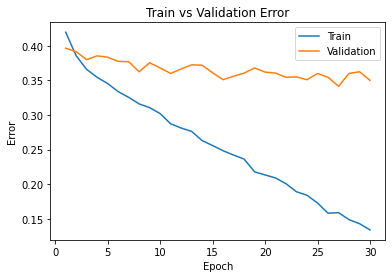

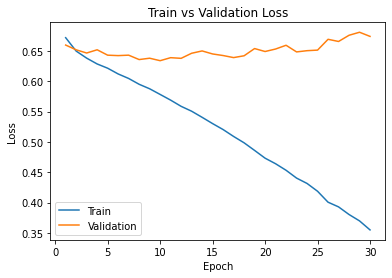

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.002 16
Total time elapsed: 59.42 seconds
Training Error and loss: (0.25375, 0.5282584062218666)
Validation Error and loss: (0.36, 0.6400938677787781)


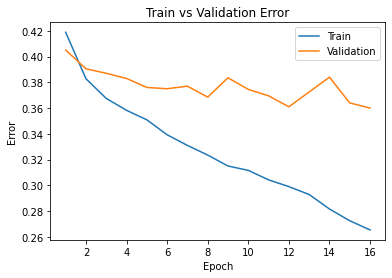

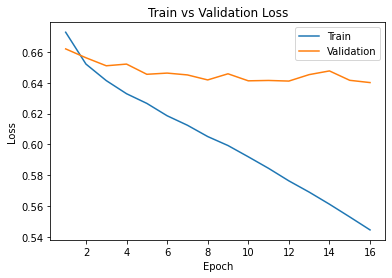

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.002 30
Total time elapsed: 111.15 seconds
Training Error and loss: (0.15425, 0.394343983232975)
Validation Error and loss: (0.352, 0.6554796075820923)


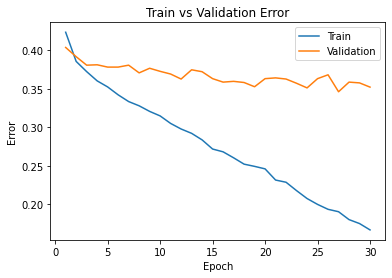

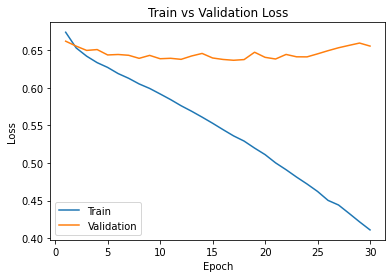

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.002 16
Total time elapsed: 56.03 seconds
Training Error and loss: (0.2735, 0.5507048073978651)
Validation Error and loss: (0.3695, 0.6426814539091927)


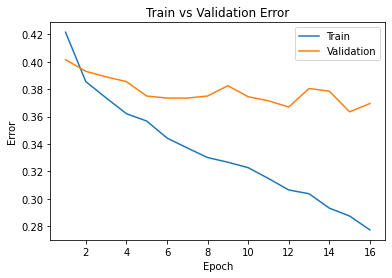

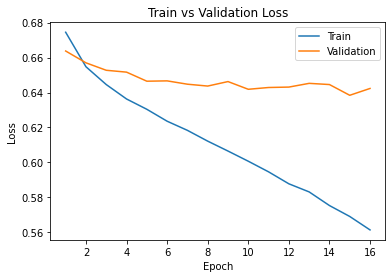

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.002 30
Total time elapsed: 108.91 seconds
Training Error and loss: (0.177125, 0.43315798328036353)
Validation Error and loss: (0.3535, 0.6445067042396182)


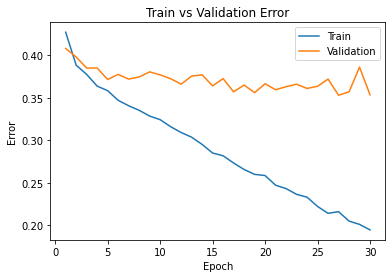

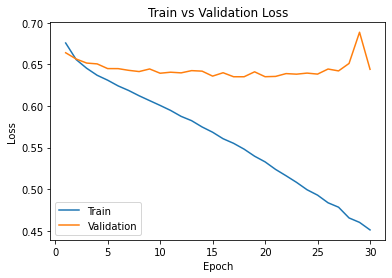

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.001 16
Total time elapsed: 65.02 seconds
Training Error and loss: (0.2725, 0.550090255137689)
Validation Error and loss: (0.3615, 0.6398025325366429)


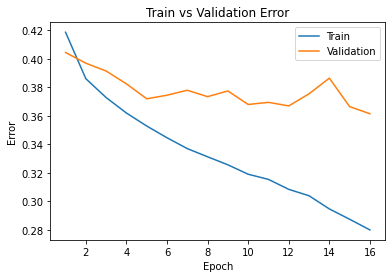

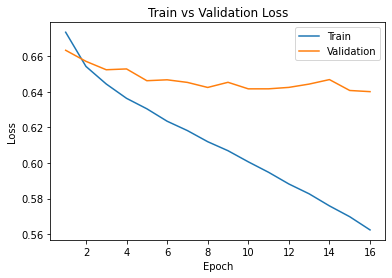

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 48 0.001 30
Total time elapsed: 124.62 seconds
Training Error and loss: (0.18275, 0.43585812403056434)
Validation Error and loss: (0.3495, 0.6448658506075541)


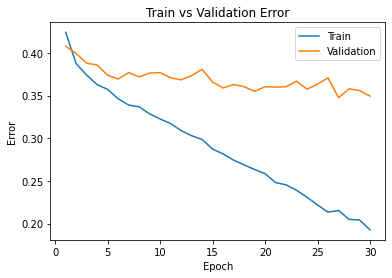

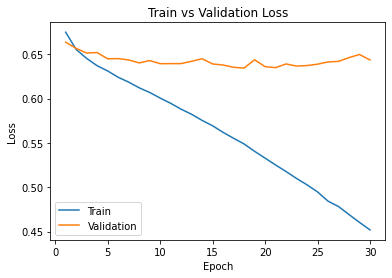

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.001 16
Total time elapsed: 61.05 seconds
Training Error and loss: (0.29625, 0.5767332634925842)
Validation Error and loss: (0.3685, 0.6435634847730398)


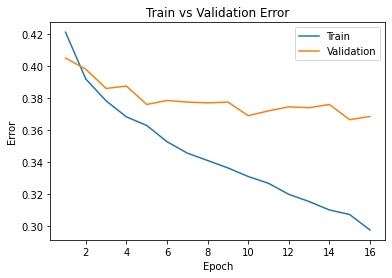

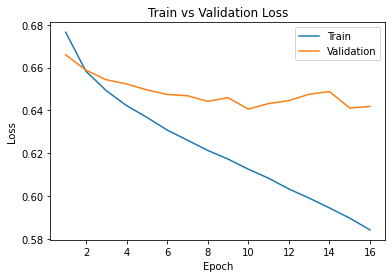

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 64 0.001 30
Total time elapsed: 117.44 seconds
Training Error and loss: (0.218875, 0.4929287502765656)
Validation Error and loss: (0.3585, 0.6340661775320768)


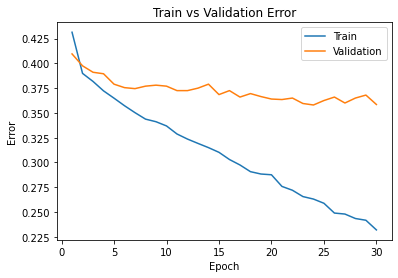

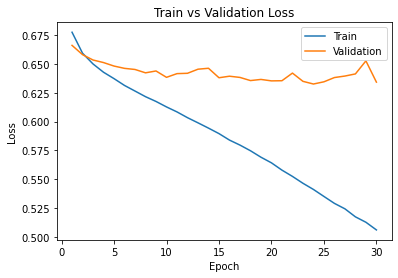

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.001 16
Total time elapsed: 59.60 seconds
Training Error and loss: (0.309, 0.5923591536283493)
Validation Error and loss: (0.3685, 0.6419368577003479)


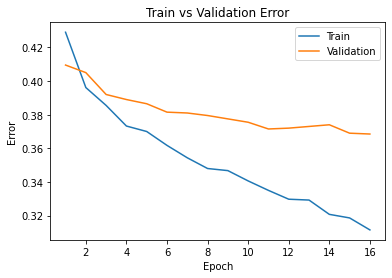

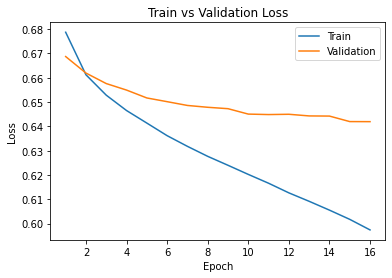

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 80 0.001 30
Total time elapsed: 116.51 seconds
Training Error and loss: (0.249, 0.528451279103756)
Validation Error and loss: (0.3665, 0.6365625762939453)


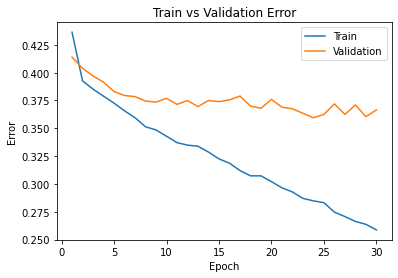

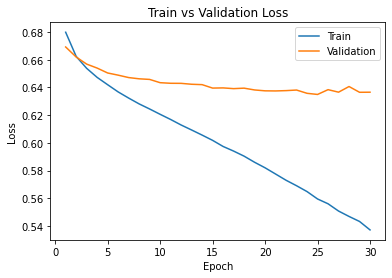

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.001 16
Total time elapsed: 57.22 seconds
Training Error and loss: (0.318625, 0.602853386884644)
Validation Error and loss: (0.372, 0.6427666828745887)


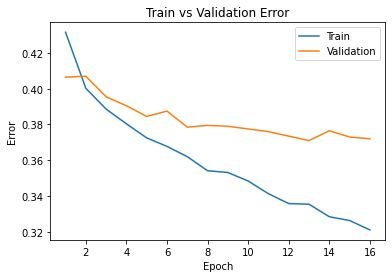

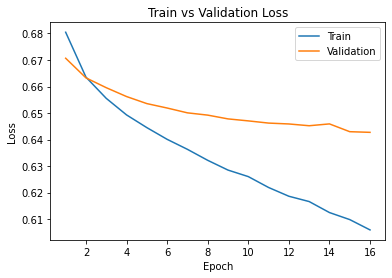

Files already downloaded and verified
Files already downloaded and verified
Finished Training 2 layer NN with: 96 0.001 30
Total time elapsed: 108.36 seconds
Training Error and loss: (0.272625, 0.5520840524917557)
Validation Error and loss: (0.3695, 0.6397737264633179)


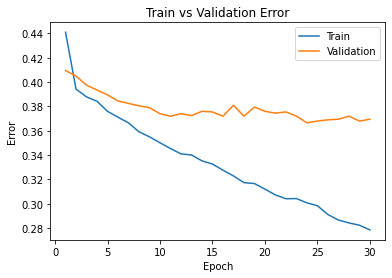

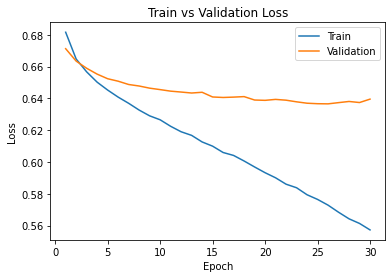

In [158]:
# Train the model with varying hyperparameters
learning_rates = [0.004, 0.003, 0.002, 0.001]
batch_sizes = [48, 64, 80, 96]
epochs = [16, 30]

for i in learning_rates:
  for j in batch_sizes:
    for k in epochs:
      train_ai(batch=j, learning_rate=i, num_epochs=k)
      model_path = get_model_name(AI.name, batch_size=j, learning_rate=i, epoch=(k - 1))
      plot_training_curve(model_path)
